In [1]:
import pandas as pd
import datetime
# %pip install dataprep
# from dataprep.eda import plot, plot_correlation, create_report, plot_missing
import numpy as np
import matplotlib.cm as cm
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
# from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

import dataset

https://www.kaggle.com/imakash3011/customer-analysis-eda-report-clustering

https://github.com/g-aditi/customer-personality-analysis/blob/main/CustomerPersonalityAnalysis.ipynb

In [2]:
df=pd.read_csv('marketing_campaign.csv', sep='\t')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [3]:
df.shape

(2240, 29)

check for null values

In [4]:
df.isna().any()

ID                     False
Year_Birth             False
Education              False
Marital_Status         False
Income                  True
Kidhome                False
Teenhome               False
Dt_Customer            False
Recency                False
MntWines               False
MntFruits              False
MntMeatProducts        False
MntFishProducts        False
MntSweetProducts       False
MntGoldProds           False
NumDealsPurchases      False
NumWebPurchases        False
NumCatalogPurchases    False
NumStorePurchases      False
NumWebVisitsMonth      False
AcceptedCmp3           False
AcceptedCmp4           False
AcceptedCmp5           False
AcceptedCmp1           False
AcceptedCmp2           False
Complain               False
Z_CostContact          False
Z_Revenue              False
Response               False
dtype: bool

In [5]:
df.dropna(inplace=True)
df.shape

(2216, 29)

check unique value and remove columns with one unique value

In [6]:
df.nunique()

ID                     2216
Year_Birth               59
Education                 5
Marital_Status            8
Income                 1974
Kidhome                   3
Teenhome                  3
Dt_Customer             662
Recency                 100
MntWines                776
MntFruits               158
MntMeatProducts         554
MntFishProducts         182
MntSweetProducts        176
MntGoldProds            212
NumDealsPurchases        15
NumWebPurchases          15
NumCatalogPurchases      14
NumStorePurchases        14
NumWebVisitsMonth        16
AcceptedCmp3              2
AcceptedCmp4              2
AcceptedCmp5              2
AcceptedCmp1              2
AcceptedCmp2              2
Complain                  2
Z_CostContact             1
Z_Revenue                 1
Response                  2
dtype: int64

Columns Z_CostContact and Z_Revenue have the same value in each row, so they wont contribute to the model

In [7]:
df=df.drop(columns=["Z_CostContact", "Z_Revenue"],axis=1)
df.shape

(2216, 27)

## data cleaning

1. marital status

In [8]:
df['Marital_Status'].value_counts() 

Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64

In [9]:
df['Marital_Status'] = df['Marital_Status'].replace(['Married', 'Together'],1)
df['Marital_Status'] = df['Marital_Status'].replace(['Divorced', 'Widow', 'Alone', 'YOLO', 'Absurd', 'Single'],0)
df.rename(columns={'Marital_Status': 'In_Relationship'}, inplace=True)
df['In_Relationship'].value_counts()

1    1430
0     786
Name: In_Relationship, dtype: int64

2.education

In [10]:
df['Education'] = df['Education'].replace(['PhD','2n Cycle','Master'],2)  
df['Education'] = df['Education'].replace(['Graduation'],1)
df['Education'] = df['Education'].replace(['Basic'],0)
df['Education'].value_counts()

1    1116
2    1046
0      54
Name: Education, dtype: int64

3. age

In [11]:
df['Age'] = datetime.datetime.now().year - df["Year_Birth"]
df['Age'].head()

0    65
1    68
2    57
3    38
4    41
Name: Age, dtype: int64

4. kids

In [12]:
df['Kids'] = df['Kidhome'] + df['Teenhome']
df['Kids'].head()

0    0
1    2
2    0
3    1
4    1
Name: Kids, dtype: int64

5. calculate loyal days

In [13]:
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])
# df['loyal_days']=(datetime.datetime.now().normalize()- df['Dt_Customer'])
df['loyal_days']=(pd.Timestamp.now().normalize()- df['Dt_Customer']).dt.days
df.head()

,ID,Year_Birth,Education,In_Relationship,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Kids,loyal_days
0,5524,1957,1,0,58138.0,0,0,2012-04-09,58,635,...,0,0,0,0,0,0,1,65,0,3818
1,2174,1954,1,0,46344.0,1,1,2014-08-03,38,11,...,0,0,0,0,0,0,0,68,2,2972
2,4141,1965,1,1,71613.0,0,0,2013-08-21,26,426,...,0,0,0,0,0,0,0,57,0,3319
3,6182,1984,1,1,26646.0,1,0,2014-10-02,26,11,...,0,0,0,0,0,0,0,38,1,2912
4,5324,1981,2,1,58293.0,1,0,2014-01-19,94,173,...,0,0,0,0,0,0,0,41,1,3168


5. add columns expenditure, purchases and total campaign

In [14]:
df['Total_Expenditure'] = df.filter(like='Mnt').sum(axis=1)
df['Total_Purchases'] = df.filter(regex='Num[^Deals].+Purchases').sum(axis=1)
df['TotalAcceptedCmp'] = df['AcceptedCmp1'] + df['AcceptedCmp2'] + df['AcceptedCmp3'] + df['AcceptedCmp4'] + df['AcceptedCmp5'] + df['Response']

6. filter age and income

In [15]:
# https://stackoverflow.com/questions/34682828/extracting-specific-selected-columns-to-new-dataframe-as-a-copy
df1=df.iloc[: , [2,3,4,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32]].copy() 
df1.drop(df1[(df1['Age'] > 80) | (df1['Income'] > 100000)].index, inplace=True)
df1.head()

,Education,In_Relationship,Income,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Kids,loyal_days,Total_Expenditure,Total_Purchases,TotalAcceptedCmp
0,1,0,58138.0,635,88,546,172,88,88,3,...,0,0,0,1,65,0,3818,1617,22,1
1,1,0,46344.0,11,1,6,2,1,6,2,...,0,0,0,0,68,2,2972,27,4,0
2,1,1,71613.0,426,49,127,111,21,42,1,...,0,0,0,0,57,0,3319,776,20,0
3,1,1,26646.0,11,4,20,10,3,5,2,...,0,0,0,0,38,1,2912,53,6,0
4,2,1,58293.0,173,43,118,46,27,15,5,...,0,0,0,0,41,1,3168,422,14,0


In [16]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2198 entries, 0 to 2239
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2198 non-null   int64  
 1   In_Relationship      2198 non-null   int64  
 2   Income               2198 non-null   float64
 3   MntWines             2198 non-null   int64  
 4   MntFruits            2198 non-null   int64  
 5   MntMeatProducts      2198 non-null   int64  
 6   MntFishProducts      2198 non-null   int64  
 7   MntSweetProducts     2198 non-null   int64  
 8   MntGoldProds         2198 non-null   int64  
 9   NumDealsPurchases    2198 non-null   int64  
 10  NumWebPurchases      2198 non-null   int64  
 11  NumCatalogPurchases  2198 non-null   int64  
 12  NumStorePurchases    2198 non-null   int64  
 13  NumWebVisitsMonth    2198 non-null   int64  
 14  AcceptedCmp3         2198 non-null   int64  
 15  AcceptedCmp4         2198 non-null   i

## method 1 spearman correlation

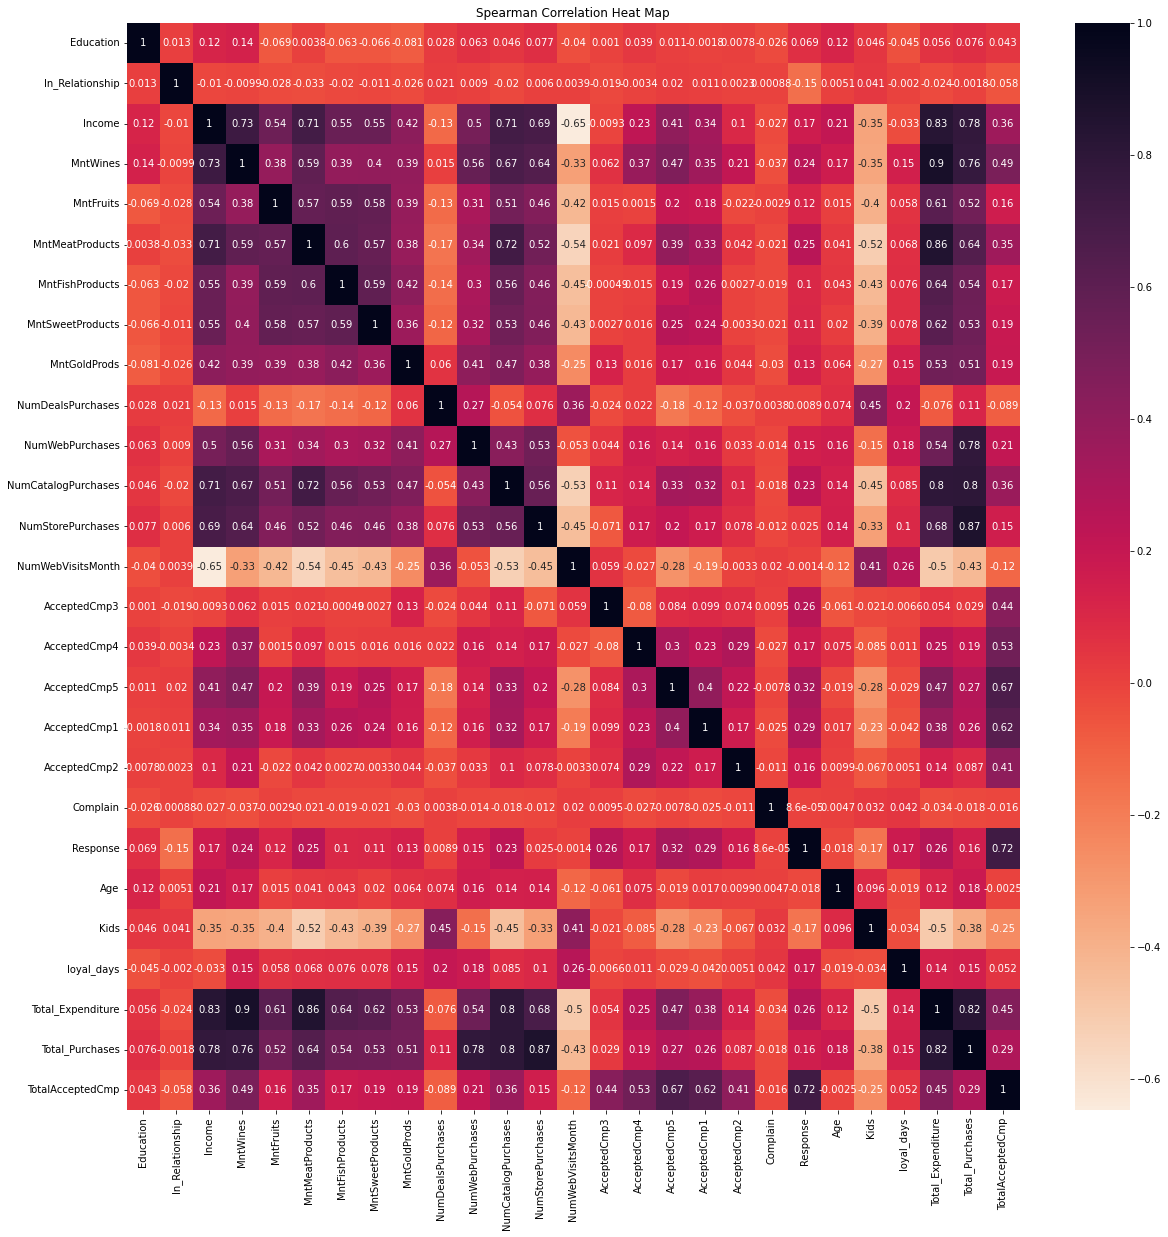

In [17]:
plt.figure(figsize=(20,20))
sns.heatmap(df1.corr(), annot=True, cmap='rocket_r')
# https://seaborn.pydata.org/tutorial/color_palettes.html
plt.title('Spearman Correlation Heat Map')
plt.show()

slicing dataset to use for clustering

** cleaned dataset is df1**

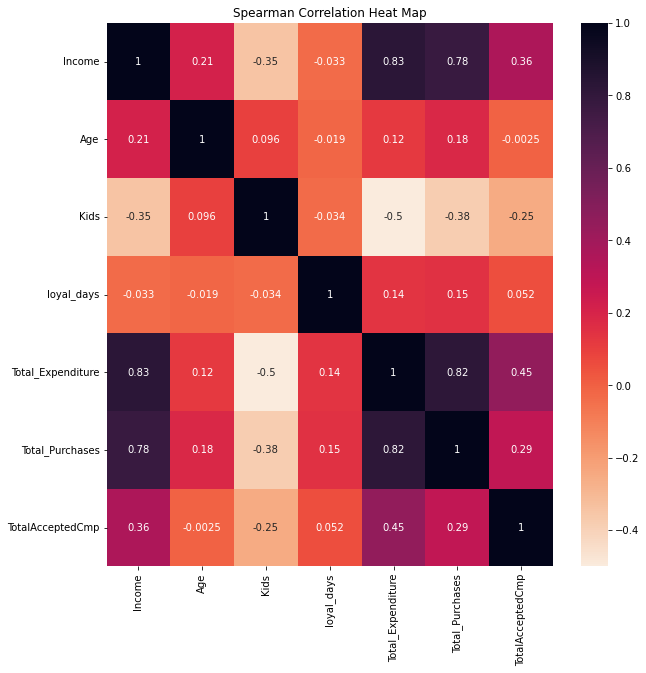

In [18]:
df1_sliced=df1.iloc[: , [2,21,22,23,24,25,26]].copy() 
plt.figure(figsize=(10,10))
sns.heatmap(df1_sliced.corr(), annot=True, cmap='rocket_r')
# https://seaborn.pydata.org/tutorial/color_palettes.html
plt.title('Spearman Correlation Heat Map')
plt.show()

scale the dataset

In [19]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df1_sliced)
scaled_ds = pd.DataFrame(scaled,index=df1_sliced.index,columns= df1_sliced.columns )
print(scaled_ds)

        Income       Age      Kids  loyal_days  Total_Expenditure  \
0     0.581244  0.735849  0.000000    0.913452           0.639683   
1     0.459715  0.792453  0.666667    0.117592           0.008730   
2     0.720094  0.584906  0.000000    0.444026           0.305952   
3     0.256742  0.226415  0.333333    0.061148           0.019048   
4     0.582841  0.283019  0.333333    0.301976           0.165476   
...        ...       ...       ...         ...                ...   
2235  0.613033  0.547170  0.333333    0.508937           0.530159   
2236  0.641792  0.943396  1.000000    0.057385           0.174206   
2237  0.569322  0.283019  0.000000    0.296331           0.490476   
2238  0.695694  0.754717  0.333333    0.297272           0.332540   
2239  0.526951  0.792453  0.666667    0.735654           0.066270   

      Total_Purchases  TotalAcceptedCmp  
0             0.68750               0.2  
1             0.12500               0.0  
2             0.62500               0.0  
3  

k means elbow method

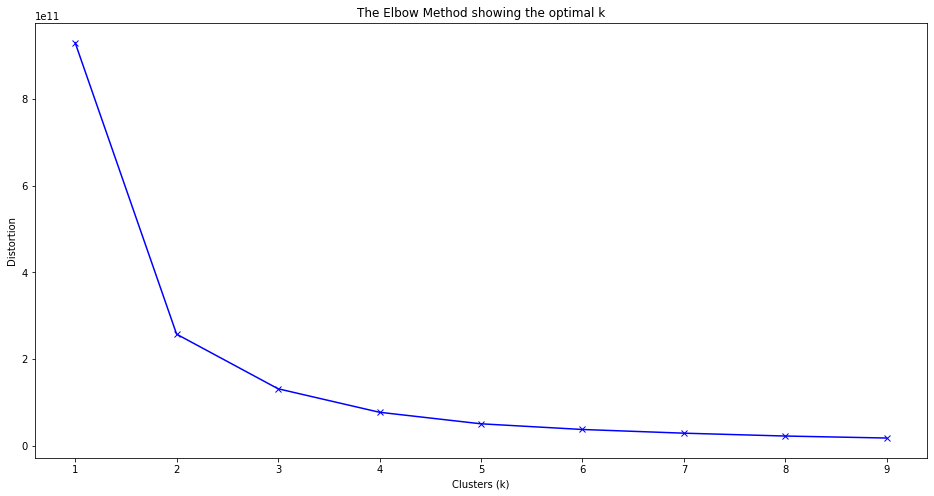

In [20]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=0)
    kmeanModel.fit(df1_sliced)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Clusters (k)')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

3 is the optimum number of clusters from the cluster method.

In [21]:
# Gaussian Mixture method

https://analyticsindiamag.com/gaussian-mixture-model-clustering-vs-k-means-which-one-to-choose/


In [22]:
#scaled
from sklearn.mixture import GaussianMixture
n_clusters = 3
gmm_model = GaussianMixture(n_components=n_clusters)
gmm_model.fit(scaled_ds)
cluster_labels = gmm_model.predict(scaled_ds)
scaled_ds = pd.DataFrame(scaled_ds)
scaled_ds['cluster'] = cluster_labels


In [23]:
from sklearn.mixture import GaussianMixture
n_clusters = 3
gmm_model = GaussianMixture(n_components=n_clusters, random_state=0)
gmm_model.fit(scaled_ds)
y_cluster_gmm = gmm_model.predict(scaled_ds)

# from coclust.evaluation.external import accuracy
# accuracy(labels, predicted_labels)



In [24]:
# %pip install scikit_posthocs
# import scikit_posthocs as sp
# sp.posthoc_dunn(y_cluster_gmm, p_adjust = 'holm')

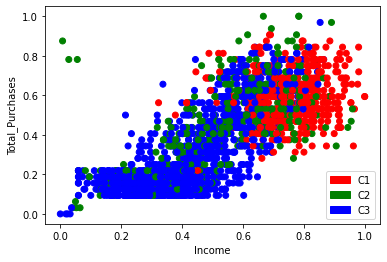

In [25]:
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='C1')
green_patch = mpatches.Patch(color='green', label='C2')
blue_patch = mpatches.Patch(color='blue', label='C3')
colors = np.array(['blue', 'red', 'green'])
plt.scatter(scaled_ds.iloc[:, 0],scaled_ds.iloc[:, 5],c=colors[y_cluster_gmm])
plt.xlabel("Income")
plt.ylabel("Total_Purchases")
plt.legend(handles=[red_patch, green_patch, blue_patch])
plt.show()

In [26]:
# K-Means Clustering

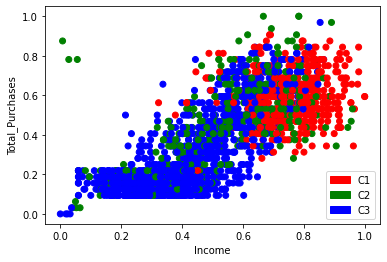

In [27]:
nclusters = 3 # this is the k in kmeans
km = KMeans(n_clusters=nclusters, random_state=0)
km.fit(scaled_ds)
# predict the cluster for each data point
y_cluster_kmeans = km.predict(scaled_ds)
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='C1')
green_patch = mpatches.Patch(color='green', label='C2')
blue_patch = mpatches.Patch(color='blue', label='C3')
colors = np.array(['blue', 'red', 'green'])
plt.scatter(scaled_ds.iloc[:, 0],scaled_ds.iloc[:, 5],c=colors[y_cluster_kmeans])
plt.xlabel("Income")
plt.ylabel("Total_Purchases")
plt.legend(handles=[red_patch, green_patch, blue_patch])
plt.show()

https://builtin.com/data-science/data-clustering-python

In [28]:
# Spectral Clustering

[Text(0.5, 1.0, 'Spectral Clustering')]

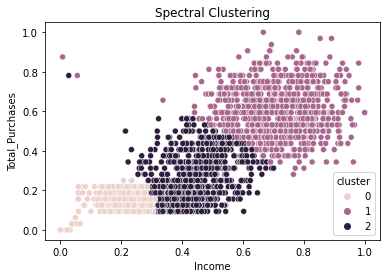

In [29]:
from sklearn.cluster import SpectralClustering
sm= SpectralClustering(n_clusters=3, random_state=25, n_neighbors=60, affinity='nearest_neighbors')
scaled_ds['cluster'] = sm.fit_predict(scaled_ds[['Income', 'Total_Purchases']])
fig, ax = plt.subplots()
sns.scatterplot(x='Income', y='Total_Purchases', data=scaled_ds, hue='cluster', ax=ax)
ax.set(title='Spectral Clustering')

https://www.analyticsvidhya.com/blog/2021/05/what-why-and-how-of-spectral-clustering/

In [30]:
# https://machinelearningmastery.com/clustering-algorithms-with-python/

In [31]:
pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [32]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from xgboost import plot_importance
import matplotlib.pyplot as plt
from numpy import sort
from sklearn.feature_selection import SelectFromModel

In [33]:
df1_sliced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2198 entries, 0 to 2239
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Income             2198 non-null   float64
 1   Age                2198 non-null   int64  
 2   Kids               2198 non-null   int64  
 3   loyal_days         2198 non-null   int64  
 4   Total_Expenditure  2198 non-null   int64  
 5   Total_Purchases    2198 non-null   int64  
 6   TotalAcceptedCmp   2198 non-null   int64  
dtypes: float64(1), int64(6)
memory usage: 137.4 KB


In [34]:
train_df = df1.drop(['Education', 'loyal_days', 'Kids', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3','AcceptedCmp4', 'AcceptedCmp5'], axis=1)
col_mask=train_df.isnull().any(axis=0)
row_mask=train_df.isnull().any(axis=1)

In [35]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2198 entries, 0 to 2239
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   In_Relationship      2198 non-null   int64  
 1   Income               2198 non-null   float64
 2   MntWines             2198 non-null   int64  
 3   MntFruits            2198 non-null   int64  
 4   MntMeatProducts      2198 non-null   int64  
 5   MntFishProducts      2198 non-null   int64  
 6   MntSweetProducts     2198 non-null   int64  
 7   MntGoldProds         2198 non-null   int64  
 8   NumDealsPurchases    2198 non-null   int64  
 9   NumWebPurchases      2198 non-null   int64  
 10  NumCatalogPurchases  2198 non-null   int64  
 11  NumStorePurchases    2198 non-null   int64  
 12  NumWebVisitsMonth    2198 non-null   int64  
 13  Complain             2198 non-null   int64  
 14  Response             2198 non-null   int64  
 15  Age                  2198 non-null   i

In [36]:
#create_report(train_df)

In [37]:
train_df[train_df == np.inf]=np.nan
train_df.fillna(train_df.median(), inplace=True)

In [38]:
X, y = train_df.loc[:, train_df.columns != 'TotalAcceptedCmp'], train_df['TotalAcceptedCmp']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

model = XGBClassifier(learning_rate = 0.05, n_estimators=300, max_depth=5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 79.77%


In [39]:

thresholds = sort(model.feature_importances_)
for threshold in thresholds:
    selection = SelectFromModel(model, threshold=threshold, prefit=True)
    select_X_train = selection.transform(X_train)
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (threshold, select_X_train.shape[1], accuracy*100.0))

Thresh=0.000, n=18, Accuracy: 81.59%
Thresh=0.028, n=17, Accuracy: 81.59%
Thresh=0.030, n=16, Accuracy: 80.91%
Thresh=0.030, n=15, Accuracy: 81.59%
Thresh=0.032, n=14, Accuracy: 82.27%
Thresh=0.032, n=13, Accuracy: 82.50%
Thresh=0.033, n=12, Accuracy: 80.91%
Thresh=0.033, n=11, Accuracy: 81.36%
Thresh=0.035, n=10, Accuracy: 81.36%
Thresh=0.035, n=9, Accuracy: 81.14%
Thresh=0.036, n=8, Accuracy: 80.91%
Thresh=0.038, n=7, Accuracy: 79.77%
Thresh=0.038, n=6, Accuracy: 80.45%
Thresh=0.038, n=5, Accuracy: 80.00%
Thresh=0.042, n=4, Accuracy: 80.68%
Thresh=0.043, n=3, Accuracy: 79.32%
Thresh=0.079, n=2, Accuracy: 75.45%
Thresh=0.399, n=1, Accuracy: 77.95%


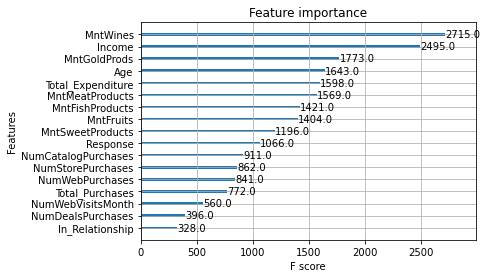

In [40]:
plot_importance(model)
plt.show()

In [41]:
# from sklearn import cluster, datasets, mixture
# from sklearn.neighbors import kneighbors_graph
# from sklearn.preprocessing import StandardScaler
# from itertools import cycle, islice

# clt = cluster.AffinityPropagation(damping=0.5, max_iter=500, affinity="euclidean")
# model = clt.fit(df1_sliced)
# n_clusters_ = len(model.cluster_centers_indices_)
# print("Number of Clusters: ",n_clusters_)
# clusters = pd.DataFrame(model.fit_predict(df1_sliced))
# df1_sliced["Cluster"] = clusters
# # fig = plt.figure(figsize=(10,10)); ax = fig.add_subplot(111)
# # scatter = ax.scatter(df1[0],df1[1], c=df1["Cluster"],s=50)
# # ax.set_title("AffinityPropagation Clustering")
# # ax.set_xlabel("X0"); ax.set_ylabel("X1")
# # plt.colorbar(scatter); plt.show()

# fig, ax = plt.subplots()
# sns.scatterplot(x='Income', y='Total_Purchases', data=df1_sliced, hue='Cluster', ax=ax)
# ax.set(title='Affinity Propagation Clustering')


In [42]:
#SVM

df1_sliced.TotalAcceptedCmp.unique()


array([1, 0, 3, 2, 4, 5], dtype=int64)

In [43]:
df1_sliced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2198 entries, 0 to 2239
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Income             2198 non-null   float64
 1   Age                2198 non-null   int64  
 2   Kids               2198 non-null   int64  
 3   loyal_days         2198 non-null   int64  
 4   Total_Expenditure  2198 non-null   int64  
 5   Total_Purchases    2198 non-null   int64  
 6   TotalAcceptedCmp   2198 non-null   int64  
dtypes: float64(1), int64(6)
memory usage: 137.4 KB


In [44]:
from sklearn.model_selection import train_test_split
from collections import Counter
df_svm=df1_sliced

# X = df_svm[['Income','Age','Total_Expenditure','loyal_days']]
X = df1[['Income','MntWines']].copy()
y = df1.AcceptedCmp1

#Split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

print(Counter(y_train))

print(Counter(y_test))

Counter({0: 1642, 1: 116})
Counter({0: 418, 1: 22})


In [45]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

clf = SVC(kernel='rbf')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test,y_pred))

0.95


In [46]:
from sklearn.model_selection import GridSearchCV
 
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}
 
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
 
# fitting the model for grid search
grid.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.935 total time=   0.2s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.935 total time=   0.1s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.932 total time=   0.1s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.934 total time=   0.1s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.934 total time=   0.1s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.935 total time=   0.2s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.935 total time=   0.1s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.932 total time=   0.1s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.934 total time=   0.2s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.934 total time=   0.1s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.935 total time=   0.1s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

[CV 2/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.943 total time=   0.2s
[CV 3/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.938 total time=   0.2s
[CV 4/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.940 total time=   0.1s
[CV 5/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.943 total time=   0.1s
[CV 1/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.946 total time=   0.1s
[CV 2/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.943 total time=   0.1s
[CV 3/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.938 total time=   0.2s
[CV 4/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.940 total time=   0.2s
[CV 5/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.943 total time=   0.2s
[CV 1/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.946 total time=   0.1s
[CV 2/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.940 total time=   0.1s
[CV 3/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.938 total time=   0.1s
[CV 4/5] END ....C=1000, gam

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [47]:
from sklearn.metrics import classification_report
# print best parameter after tuning
print(grid.best_params_)
 
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 1, 'gamma': 1, 'kernel': 'rbf'}
SVC(C=1, gamma=1)


In [48]:
from sklearn.metrics import classification_report
grid_predictions = grid.predict(X_test)
# print classification report
print(classification_report(y_test, grid_predictions))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98       418
           1       1.00      0.09      0.17        22

    accuracy                           0.95       440
   macro avg       0.98      0.55      0.57       440
weighted avg       0.96      0.95      0.94       440



import sys
sys.argv = sys.argv[:1] + ['bdist_wheel'] + \
    config_settings["--global-option"]
_run_setup()
if wheel_directory != 'dist':
    shutil.rmtree(wheel_directory)
    shutil.copytree('dist', wheel_directory)